In [75]:
%matplotlib inline

import pandas as pd
import numpy as np
import re
import operator
import matplotlib.pyplot as plt

from __future__ import division
# Import the linear regression class
from sklearn.linear_model import LinearRegression
# Sklearn also has a helper that makes it easy to do cross validation
from sklearn.cross_validation import KFold
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import GradientBoostingClassifier


In [76]:
training_data = pd.read_csv("train.csv")

#Exploratory Data Analysis

In [77]:
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [78]:
training_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#Data Munging

**Notice that the age count is less than the rest of the columns, which means that we are missing data** 


What should we do about this? We have a few options:
        1. List wise deletion: Delete observations where any of the variable is missing
        2. Pair Wise Deletion: Include all cases in data analysis in which the variables of interest are present
        3. Mean/Mode Substitution: Replace missing values with the mean or mode of the other values in that column


We'll use option 3 here.


In [79]:
training_data["Age"] = training_data["Age"].fillna(training_data["Age"].median())

**We can use describe again to verify our age count is accurate**

In [80]:
training_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The numeric columns above now look ready to analyze, but what about the other remaining columns in the data? For these we need to convert them to number equivalents for our model to properly analyze them. We will not be using the ticket and name columns because those most likely will not have a impact on our model.

Let's first start with sex, we first need to see how many unique values are in the column and then come up with a numbering system to replace them.

In [81]:
training_data.Sex.unique()

array(['male', 'female'], dtype=object)

Now that we know the diffent sexes listed, we can replace them. It's easiest just to use 0 and 1 in this case.

In [82]:
training_data.loc[training_data["Sex"] == "male", "Sex"] = 0 #Use .loc for index search
training_data.loc[training_data["Sex"] == "female", "Sex"] = 1

In [83]:
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.0500,NaN,S


Now let's do the same thing to the embarked column.

In [84]:
#See if any of the values in the column are missing
training_data['Embarked'].isnull().values.any()

True

In [85]:
training_data["Embarked"].value_counts()

S    644
C    168
Q     77
dtype: int64

In [86]:
#Since the majority are S we'll fill in the blanks with S
training_data["Embarked"] = training_data["Embarked"].fillna("S")

In [87]:
#Double check to be safe
training_data['Embarked'].isnull().values.any()

False

In [88]:
training_data.loc[training_data["Embarked"] == "S", "Embarked"] = 0
training_data.loc[training_data["Embarked"] == "C", "Embarked"] = 1
training_data.loc[training_data["Embarked"] == "Q", "Embarked"] = 2

#Cross Validation

We'll use a helper from sklearn to split the data up into cross validation folds, and then train an algorithm for each fold, and make predictions.

In [89]:
# The columns we want to use as our predictors
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm class
alg = LinearRegression()

# Generate cross validation folds for data. Here we are making 3 diffierent folds.  
# It returns the row indices corresponding to train and test.
# We set random_state to ensure we get the same splits every time we run it.
kf = KFold(training_data.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    # The predictors we're using the train the algorithm.  Note how we only take the rows in the train folds.
    train_predictors = (training_data[predictors].iloc[train,:])
    # The target we're using to train the algorithm.
    train_target = training_data["Survived"].iloc[train]
    # Training the algorithm using the predictors and target.
    alg.fit(train_predictors, train_target)
    # We can now make predictions on the test fold
    test_predictions = alg.predict(training_data[predictors].iloc[test,:])
    predictions.append(test_predictions)

#Evaluating Error

We need to define some sort of error metric in order to see how accurate the model is. From the Kaggle competition description, the error metric is percentage of correct predictions. This generally involves finding the number of values in predictions that are the exact same as their counterparts in data["Survived"], and then dividing by the total number of passengers.

In [90]:
# The predictions are in three separate numpy arrays.  Concatenate them into one.  
# We concatenate them on axis 0, as they only have one axis.
predictions = np.concatenate(predictions, axis=0)

# Map predictions to outcomes (only possible outcomes are 1 and 0)
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0
accuracy = sum(predictions[predictions == training_data["Survived"]]) / len(predictions)

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [91]:
accuracy

0.7833894500561167

#Logistic Regression

Our accuracy isn't great, let's use logistic regression to map our value between 0 and 1.

In [92]:
# Initialize our algorithm
alg = LogisticRegression(random_state=1)
# Compute the accuracy score for all the cross validation folds.
scores = cross_validation.cross_val_score(alg, training_data[predictors], training_data["Survived"], cv=3)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.787878787879


This isn't great, but let's go ahead anyway so that we can get a first submission in. (We'll come back later and improve the algorithm). In order to get our submission, we have to read in the test data set from Kaggle and perform the same steps as we did on the training data.

In [93]:
test_data = pd.read_csv("test.csv")
test_data["Age"] = test_data["Age"].fillna(training_data["Age"].median())
test_data["Fare"] = test_data["Fare"].fillna(test_data["Fare"].median())
test_data.loc[test_data["Sex"] == "male", "Sex"] = 0 
test_data.loc[test_data["Sex"] == "female", "Sex"] = 1
test_data["Embarked"] = test_data["Embarked"].fillna("S")

test_data.loc[test_data["Embarked"] == "S", "Embarked"] = 0
test_data.loc[test_data["Embarked"] == "C", "Embarked"] = 1
test_data.loc[test_data["Embarked"] == "Q", "Embarked"] = 2

To generate our submission we have to train an algorithm on the training data. Then, we make predictions on the test set. Finally, we'll generate a csv file with the predictions and passenger ids.

In [94]:
# Initialize the algorithm class
alg = LogisticRegression(random_state=1)

# Train the algorithm using all the training data
alg.fit(training_data[predictors], training_data["Survived"])

# Make predictions using the test set.
predictions = alg.predict(test_data[predictors])

# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "Survived": predictions
    })

In [95]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [96]:
#export submission to csv to submit to kaggle
submission.to_csv("kaggle.csv", index=False)

#Improving first submission

In general there a few ways to improve accuracy:
        1. Use a better algorithm  
        2. Generate better features
        3. Combine multiple algorithms

Let's try a new algorithm - Random Forests. More details on random forests can be found [here.](http://www.nelsonspencer.com/blog/2015/2/15/machine-learning-supervised-learning-pt-3)

In [97]:
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where 
# a tree branch ends (the bottom points of the tree)
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)

# Compute the accuracy score for all the cross validation folds
scores = cross_validation.cross_val_score(alg, training_data[predictors], training_data["Survived"], cv=3)

# Take the mean of the scores (because we have one for each fold)
print scores.mean()

0.800224466891


#Tuning a bit

Good news! We've increased our accuracy, but let's think about how we can tweak it to get an even higher score. As you might have guessed, we can increase the number of trees (n_estimators) but because of the fact that we're averaging many predictions made on different subsets of the data, having more trees will only increase accuracy up to a point.

In addition to tweaking the number of trees, we can look at the min_samples_split and min_samples_leaf samples in order to reduce overfitting. You never want the trees to match the data perfectly because then it incompasses all of the quirks in the data and doesn't help when we present the algorithm with new data.

So we'll increase the number trees, splits, and sample leafs.

In [98]:
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)

scores = cross_validation.cross_val_score(alg, training_data[predictors], training_data["Survived"], cv=3)

print scores.mean()

0.819304152637


#Generating New Features

Awesome, another higher accuracy score!

In addition to the tweaks we made above, sometimes (depending on the data), you can try and generate new features to test on. For example with our data we could look at:

    1. The length of the name which could pertain to how rich a person was, and therefore their position on the ship
    2. The total number of people in a family (SibSp + Parch)
    
    
To generate these new features we'll have to manipulate our data like so:

In [99]:
# Generating a familysize column
training_data["FamilySize"] = training_data["SibSp"] + training_data["Parch"]

# The .apply method generates a new series
training_data["NameLength"] = training_data["Name"].apply(lambda x: len(x))

Another feature we can look at is the titles of each of the passengers using regular expressions.

In [100]:
# A function to get the title from a name
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Get all the titles and print how often each one occurs.
titles = training_data["Name"].apply(get_title)
print pd.value_counts(titles)

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

# Verify that we converted everything.
print pd.value_counts(titles)

# Add in the title column.
training_data["Title"] = titles

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
dtype: int64


We can also generate a feature indicating which family people are in. Because survival was likely highly dependent on your family and the people around you, this has a good chance at being a good feature.

To get this, we'll concatenate someone's last name with FamilySize to get a unique family id. We'll then be able to assign a code to each person based on their family id.

In [101]:
# A dictionary mapping family name to id
family_id_mapping = {}

# A function to get the id given a row
def get_family_id(row):
    # Find the last name by splitting on a comma
    last_name = row["Name"].split(",")[0]
    # Create the family id
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # Look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

# Get the family ids with the apply method
family_ids = training_data.apply(get_family_id, axis=1)

# There are a lot of family ids, so we'll compress all of the families under 3 members into one code.
family_ids[training_data["FamilySize"] < 3] = -1

# Print the count of each unique id.
print pd.value_counts(family_ids)

training_data["FamilyId"] = family_ids

-1      800
 14       8
 149      7
 63       6
 50       6
 59       6
 17       5
 384      4
 27       4
 25       4
 162      4
 8        4
 84       4
 340      4
 43       3
 269      3
 58       3
 633      2
 167      2
 280      2
 510      2
 90       2
 83       1
 625      1
 376      1
 449      1
 498      1
 588      1
dtype: int64


#Choosing Best Features

Now that we have more features to use in our algorithm, we have to choose which ones are the best. Sklearn has another helpful function that does this (SelectKBest), it eseentially goes column by column and figures out which columns correlate most closely with what we're trying to predict (Survived).

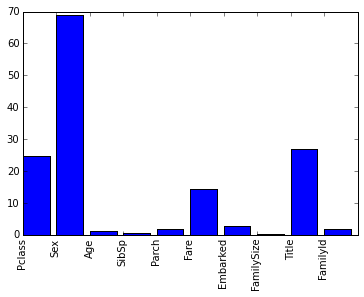

0.811447811448


In [102]:
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(training_data[predictors], training_data["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# Pick only the four best features.
predictors = ["Pclass", "Sex", "Fare", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)

# Compute the accuracy score for all the cross validation folds.  
scores = cross_validation.cross_val_score(alg, training_data[predictors], training_data["Survived"], cv=3)

# Take the mean of the scores (because we have one for each fold)
print scores.mean()

#Gradient Boosting

Another method that builds on decision trees is a gradient boosting classifier. Boosting involves training decision trees one after another, and feeding the errors from one tree into the next tree. So each tree is building on all the other trees that came before it. This can lead to overfitting if we build too many trees, though. As you get above 100 trees or so, it's very easy to overfit the dataset. As our dataset is small, we'll limit the tree count to 25.

Another way to limit overfitting is to limit the depth to which each tree in the gradient boosting process can be built. We'll limit the tree depth to 3 to avoid overfitting.

We'll try boosting instead of our random forest approach and see if we can improve our accuracy.

#Ensembling 

One thing we can do to improve the accuracy of our predictions is to ensemble different classifiers. Ensembling means that we generate predictions using information from a set of classifiers, instead of just one. In practice, this means that we average their predictions.

Generally, the more diverse the models we ensemble, the higher our accuracy will be. Diversity means that the models generate their results from different columns, or use a very different method to generate predictions. Ensembling a random forest classifier with a decision tree probably won't work extremely well, because they are very similar. On the other hand, ensembling a linear regression with a random forest can work very well.

One caveat with ensembling is that the classifiers we use have to be about the same in terms of accuracy. Ensembling one classifier that is much worse than another probably will make the final result worse.

In this case, we'll ensemble logistic regression trained on the most linear predictors (the ones that have a linear ordering, and some correlation to Survived), and a gradient boosted tree trained on all of the predictors.

We'll keep things simple when we ensemble -- we'll average the raw probabilities (from 0 to 1) that we get from our classifiers, and then assume that anything above .5 maps to one, and anything below or equal to .5 maps to 0.

In [103]:
# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

# Initialize the cross validation folds
kf = KFold(training_data.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = training_data["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(training_data[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(training_data[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == training_data["Survived"]]) / len(predictions)
print accuracy

0.819304152637


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:34: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


#Making Second Submission

Let's take everything we've done on the training set and apply it to the test set. Remember we:

        1. Generate the NameLength column, which is how long the name is
        2. Generate the FamilySize column, showing how large a family is
        3. Add in the Title column, keeping the same mapping that we had before
        4. Add in a FamilyId column, keeping the ids consistent across the train and test sets

In [104]:


# First, we'll add titles to the test set.
titles = test_data["Name"].apply(get_title)
# We're adding the Dona title to the mapping, because it's in the test set, but not the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
test_data["Title"] = titles
# Check the counts of each unique title.
print pd.value_counts(test_data["Title"])

# Now, we add the family size column.
test_data["FamilySize"] = test_data["SibSp"] + test_data["Parch"]

# Now we can add family ids.
# We'll use the same ids that we did earlier.
#print family_id_mapping

family_ids = test_data.apply(get_family_id, axis=1)
family_ids[test_data["FamilySize"] < 3] = -1
test_data["FamilyId"] = family_ids
test_data["NameLength"] = test_data["Name"].apply(lambda x: len(x))

1     240
2      79
3      72
4      21
7       2
6       2
10      1
5       1
dtype: int64


#Predict on Test Set

In [107]:
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(training_data[predictors], training_data["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(test_data[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4
predictions[predictions <= .5] = 0
predictions[predictions > .5] = 1
predictions = predictions.astype(int)
submission = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "Survived": predictions
    })


In [108]:
submission.to_csv("kaggle.csv", index=False)

#Future ideas to keep exploring:

Feature engineering:

        Try using features related to the cabins.
        See if any family size features might help -- do the number of women in a family make the whole family more    likely to survive?
        Does the national origin of the passenger's name have anything to do with survival?

The algorithm side:

        Try the random forest classifier in the ensemble.
        A support vector machine might work well with this data.
        We could try neural networks.
        Boosting with a different base classifier might work better.

Ensembling methods:

    Could majority voting be a better ensembling method than averaging probabilities?
